# Determine the scaling factor each age needs to be affine warped to be "most similar" to a 3 month old animal

1. find median pose, excluding rears
2. average median pose from all same-age animals
3. optimize scaling
4. see if I can fit a line or function to interpolate for other new ages
5. save results

In [1]:
import cv2
import h5py
import joblib
import numpy as np
import matplotlib.pyplot as plt
from aging.organization.paths import FOLDERS
from toolz import groupby, valmap, dissoc, partial
from aging.plotting import figure

In [2]:
# what scaling do I have to do to make i.e., 670, look like any of the other sizes?

def fun(scale, input_im, target_im):
    '''scale input to match target'''
    # print(scale)
    if isinstance(scale, np.ndarray):
        scale = scale[0]
    warp_mat = cv2.getRotationMatrix2D((input_im.shape[0] // 2, input_im.shape[1] // 2), 0, scale)
    out_im = cv2.warpAffine(input_im, warp_mat, input_im.shape, flags=cv2.INTER_LINEAR)
    return np.mean(np.square(target_im - out_im))

In [3]:
files = sorted(FOLDERS[1].glob("**/results_00.h5"))
files = [f for f in files if 'proc_tmp' not in f.parent.name]

In [4]:
grouped = groupby(lambda v: v.parents[2].name, files)

filtered_files = []
for file in grouped['22months_06052023']:
    with h5py.File(file, 'r') as h5f:
        sn = h5f['metadata/acquisition/SessionName'][()].decode()
        if 'CRL' not in sn:
            filtered_files.append(file)
grouped['22months_06052023'] = filtered_files

In [5]:
list(grouped)

['12months_28042021',
 '16wks_092923',
 '18months_29042021',
 '20wks_093023',
 '22months_06052023',
 '28wks_092923',
 '36wks_093023',
 '3months_19042021',
 '3wks_02112021',
 '5wks_02112021',
 '6months_20042021',
 '7wks_18112021',
 '80wks_093023',
 '84wks_092923',
 '9months_060923',
 '9wks_1811_2021']

In [6]:
def compute_frame_avg(path, thresh=9, rears=False):
    try:
        with h5py.File(path, 'r') as h5f:
            frames = h5f['frames'][()]
    
        peaks = np.quantile(frames.reshape(len(frames), -1), 0.95, axis=1)
        peaks -= np.median(peaks)
        if rears:
            med_frame = np.median(frames[peaks > thresh], axis=0)
        else:
            med_frame = np.median(frames[peaks < thresh], axis=0)
        return med_frame
    except Exception:
        return None
    
def load_and_combine(files):
    poses = [compute_frame_avg(file) for file in files]
    poses = [p for p in poses if p is not None]
    return np.mean(poses, axis=0)

In [7]:
poses = valmap(load_and_combine, grouped)

In [8]:
# for k, v in poses.items():
#     fig = figure(1, 1)
#     plt.imshow(v)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(k)

In [9]:
target = poses['3months_19042021']

In [10]:
scales = np.linspace(0.5, 1.5, 201)
pose_mses = {}
# for k, v in dissoc(poses, '3months_19042021').items():
for k, v in poses.items():
    f = partial(fun, input_im=v, target_im=target)
    mses = []
    for i in scales:
        mses.append(f(i))
    pose_mses[k] = mses

In [11]:
arr = np.array(list(pose_mses.values()))

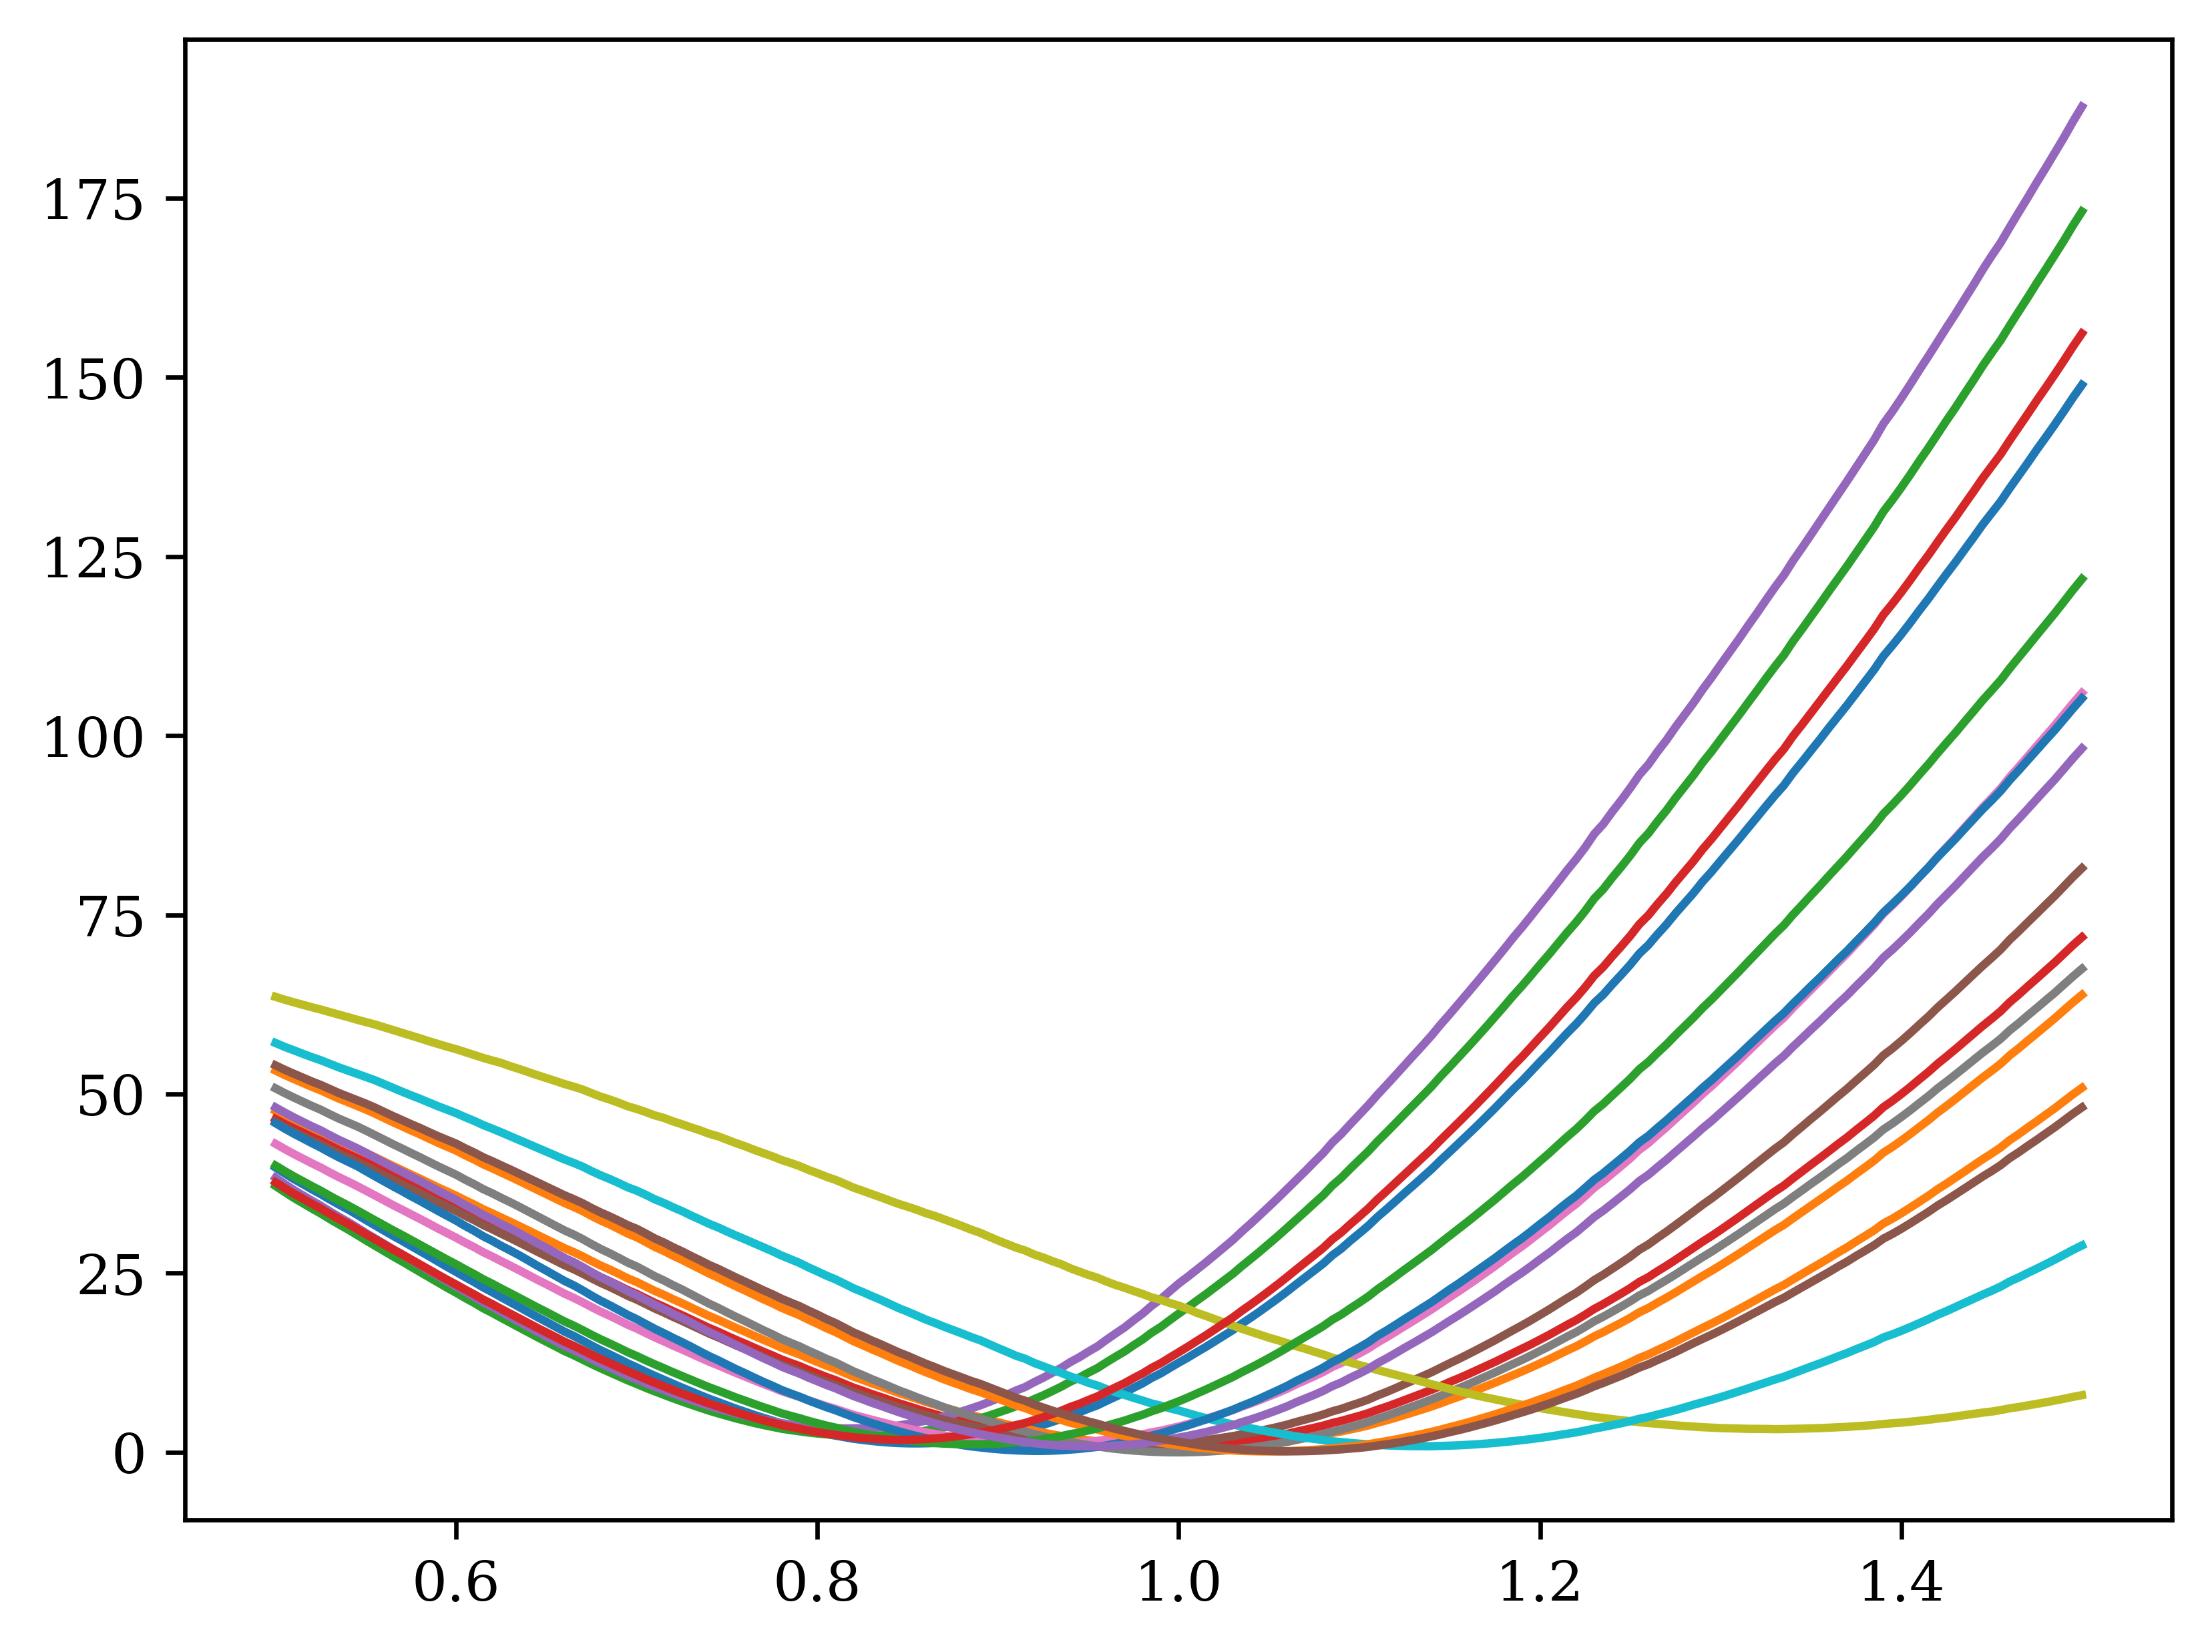

In [12]:
plt.plot(scales, arr.T)

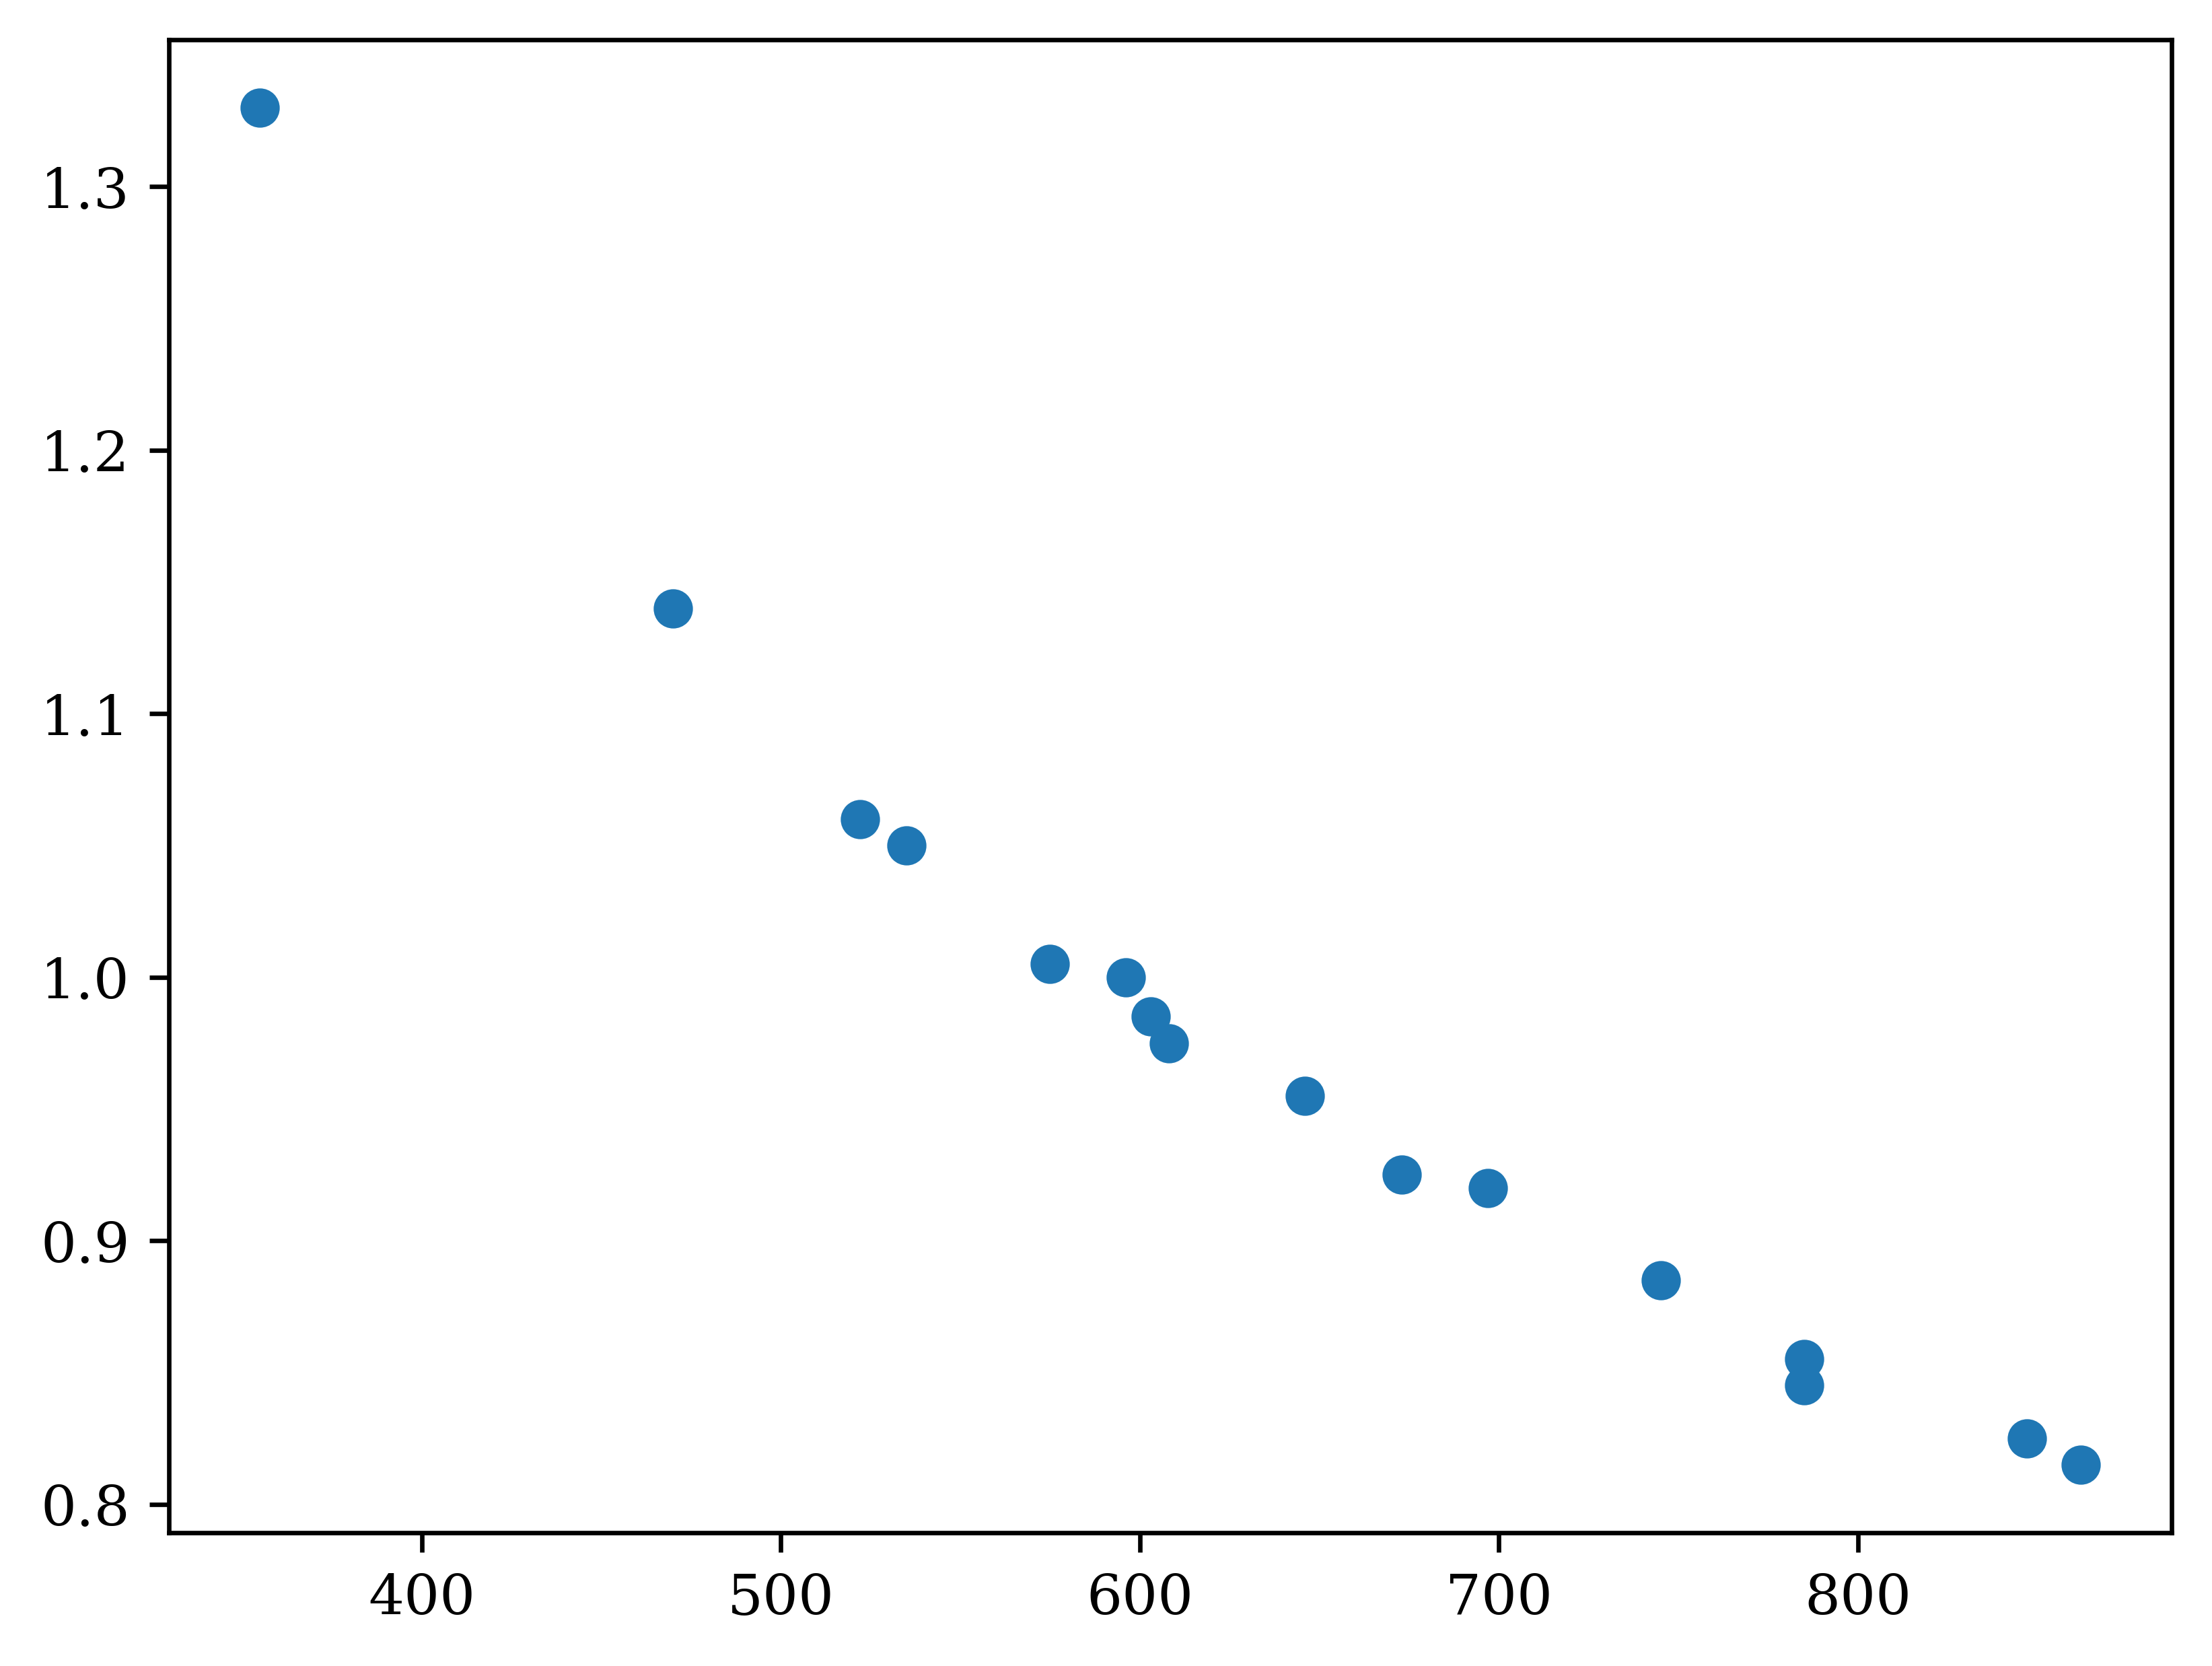

In [13]:
areas = {k: (v > 10).sum() for k, v in poses.items()}
scale_map = {k: scales[np.argmin(v)] for k, v in pose_mses.items()}

plt.plot(list(areas.values()), list(scale_map.values()), 'o')

In [14]:
x = list(areas.values())
y = list(scale_map.values())

In [15]:
coefficients_line = np.polyfit(x, y, 1)
coefficients_quad = np.polyfit(x, y, 2)

In [16]:
coefficients_line

array([-9.13471057e-04,  1.56140036e+00])

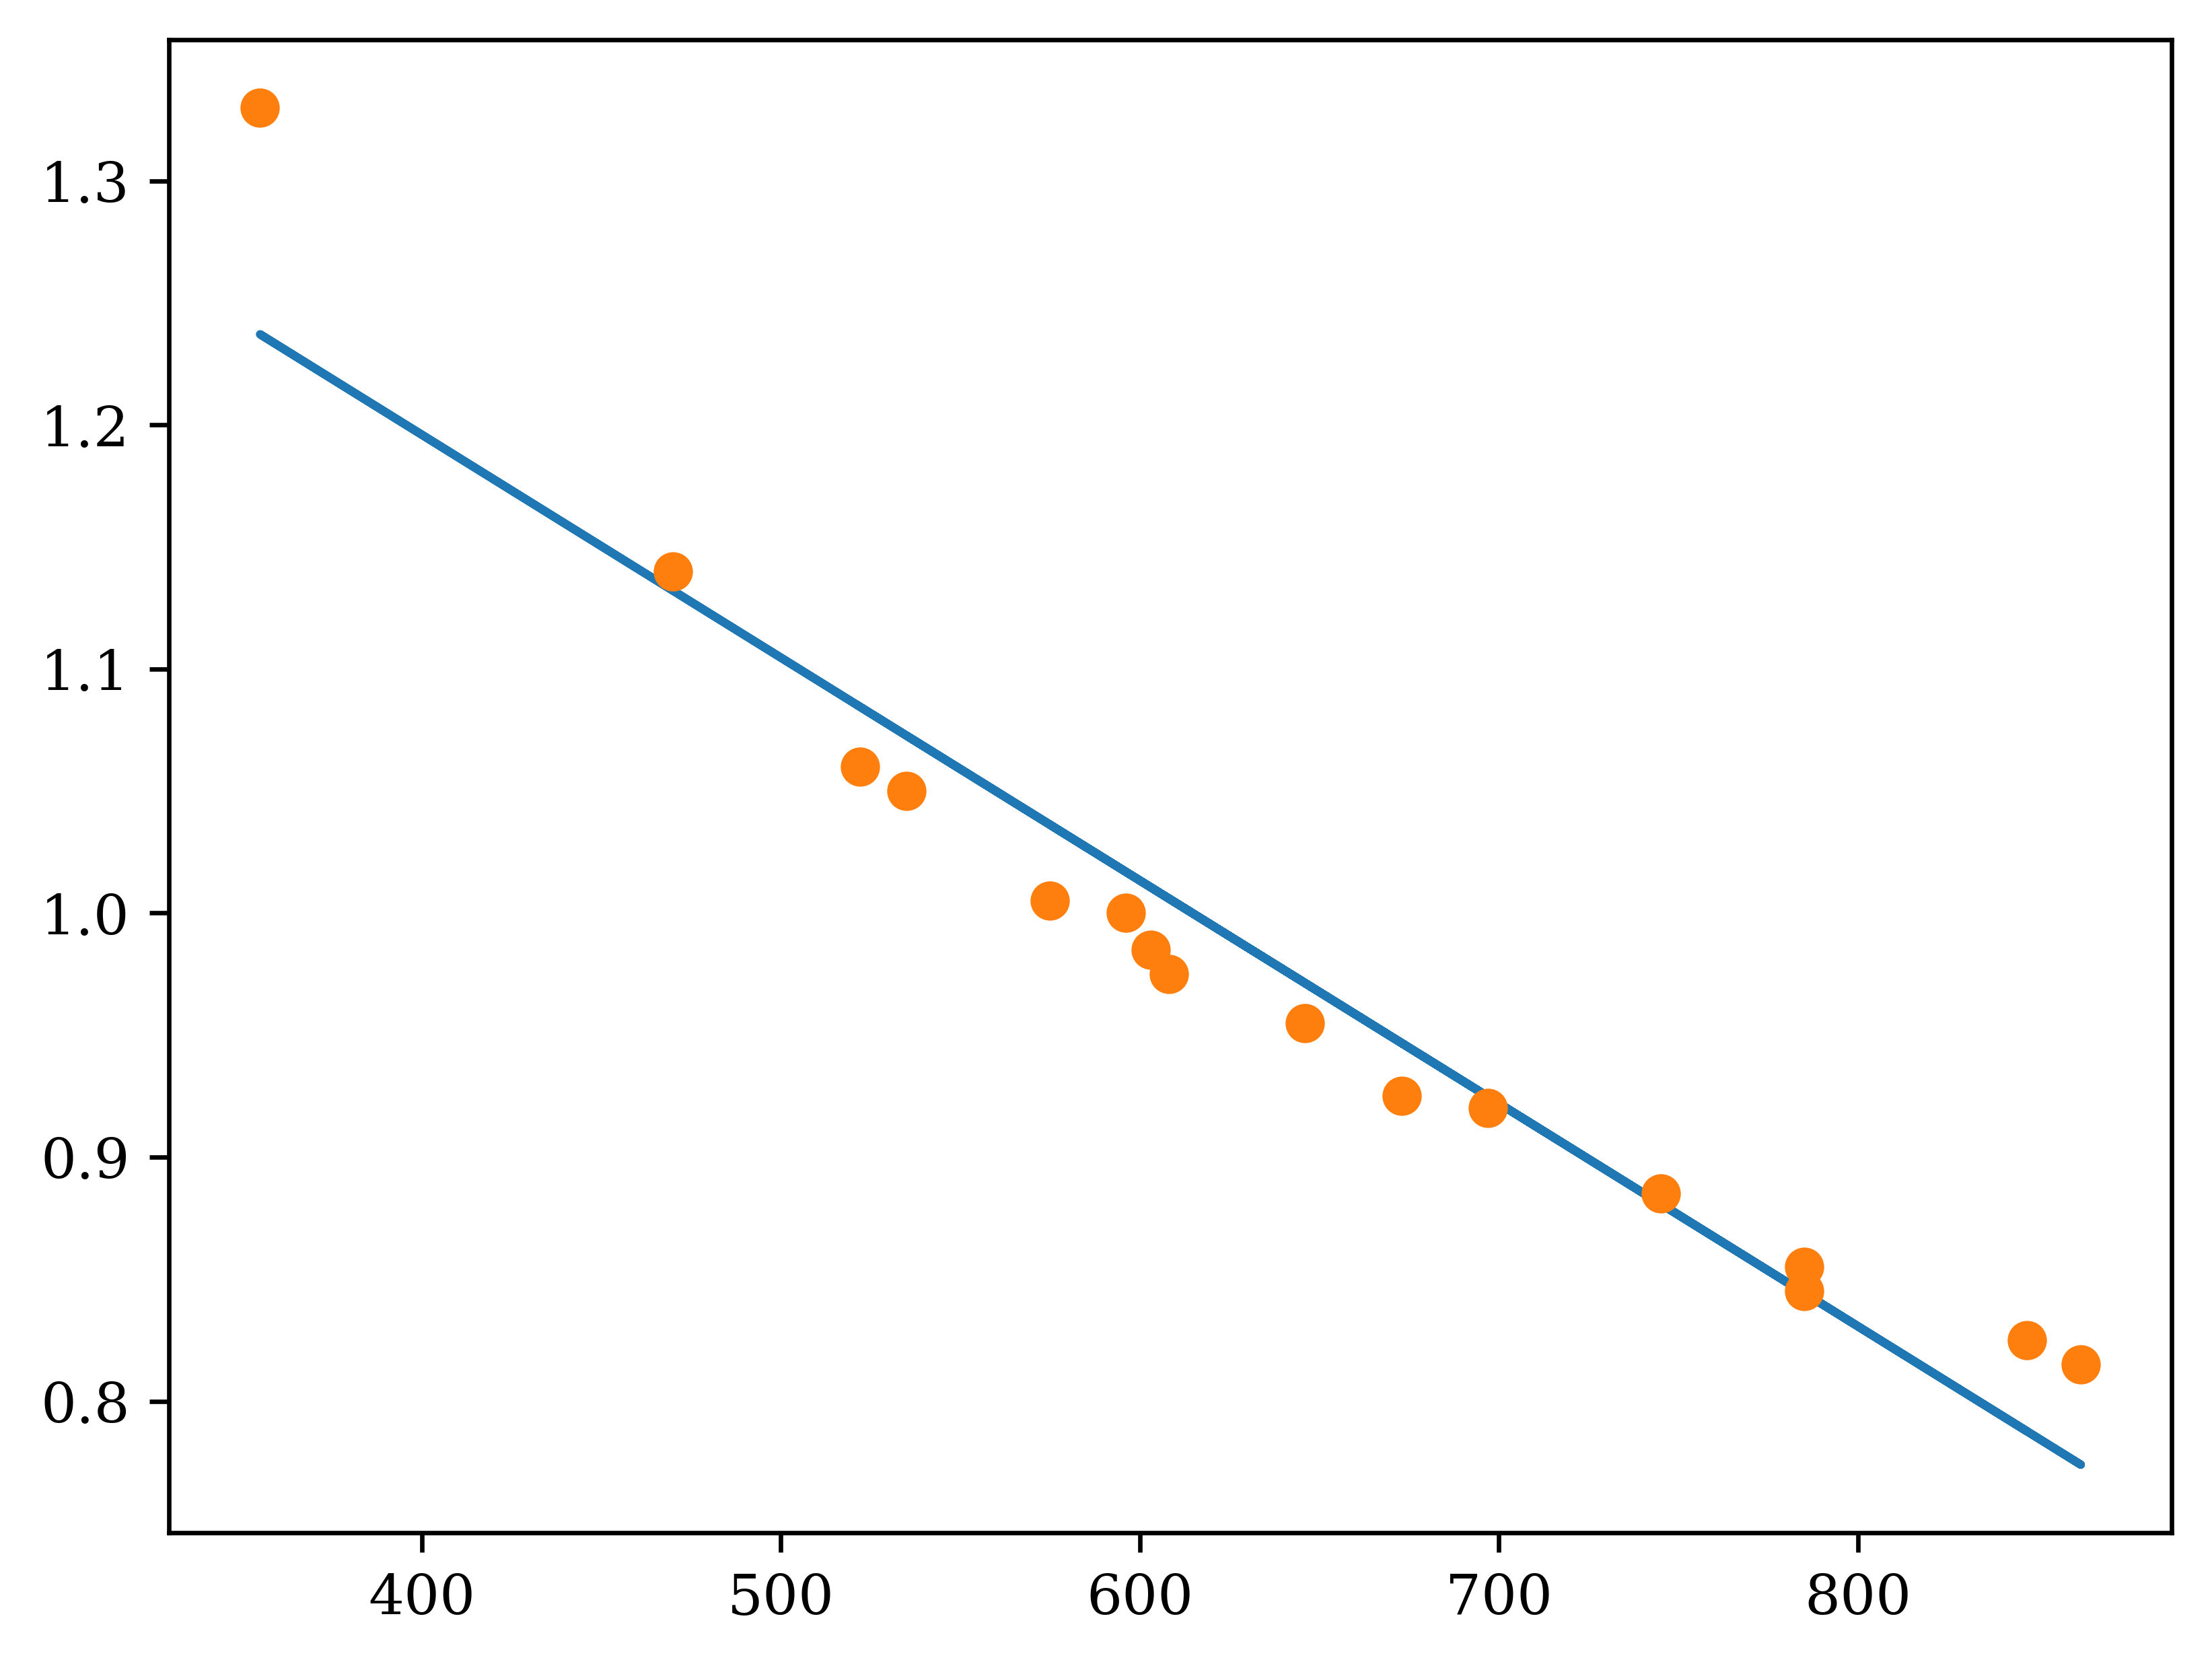

In [17]:
yhat = np.polyval(coefficients_line, x)
plt.plot(np.array(x), yhat)
plt.plot(x, y, 'o')

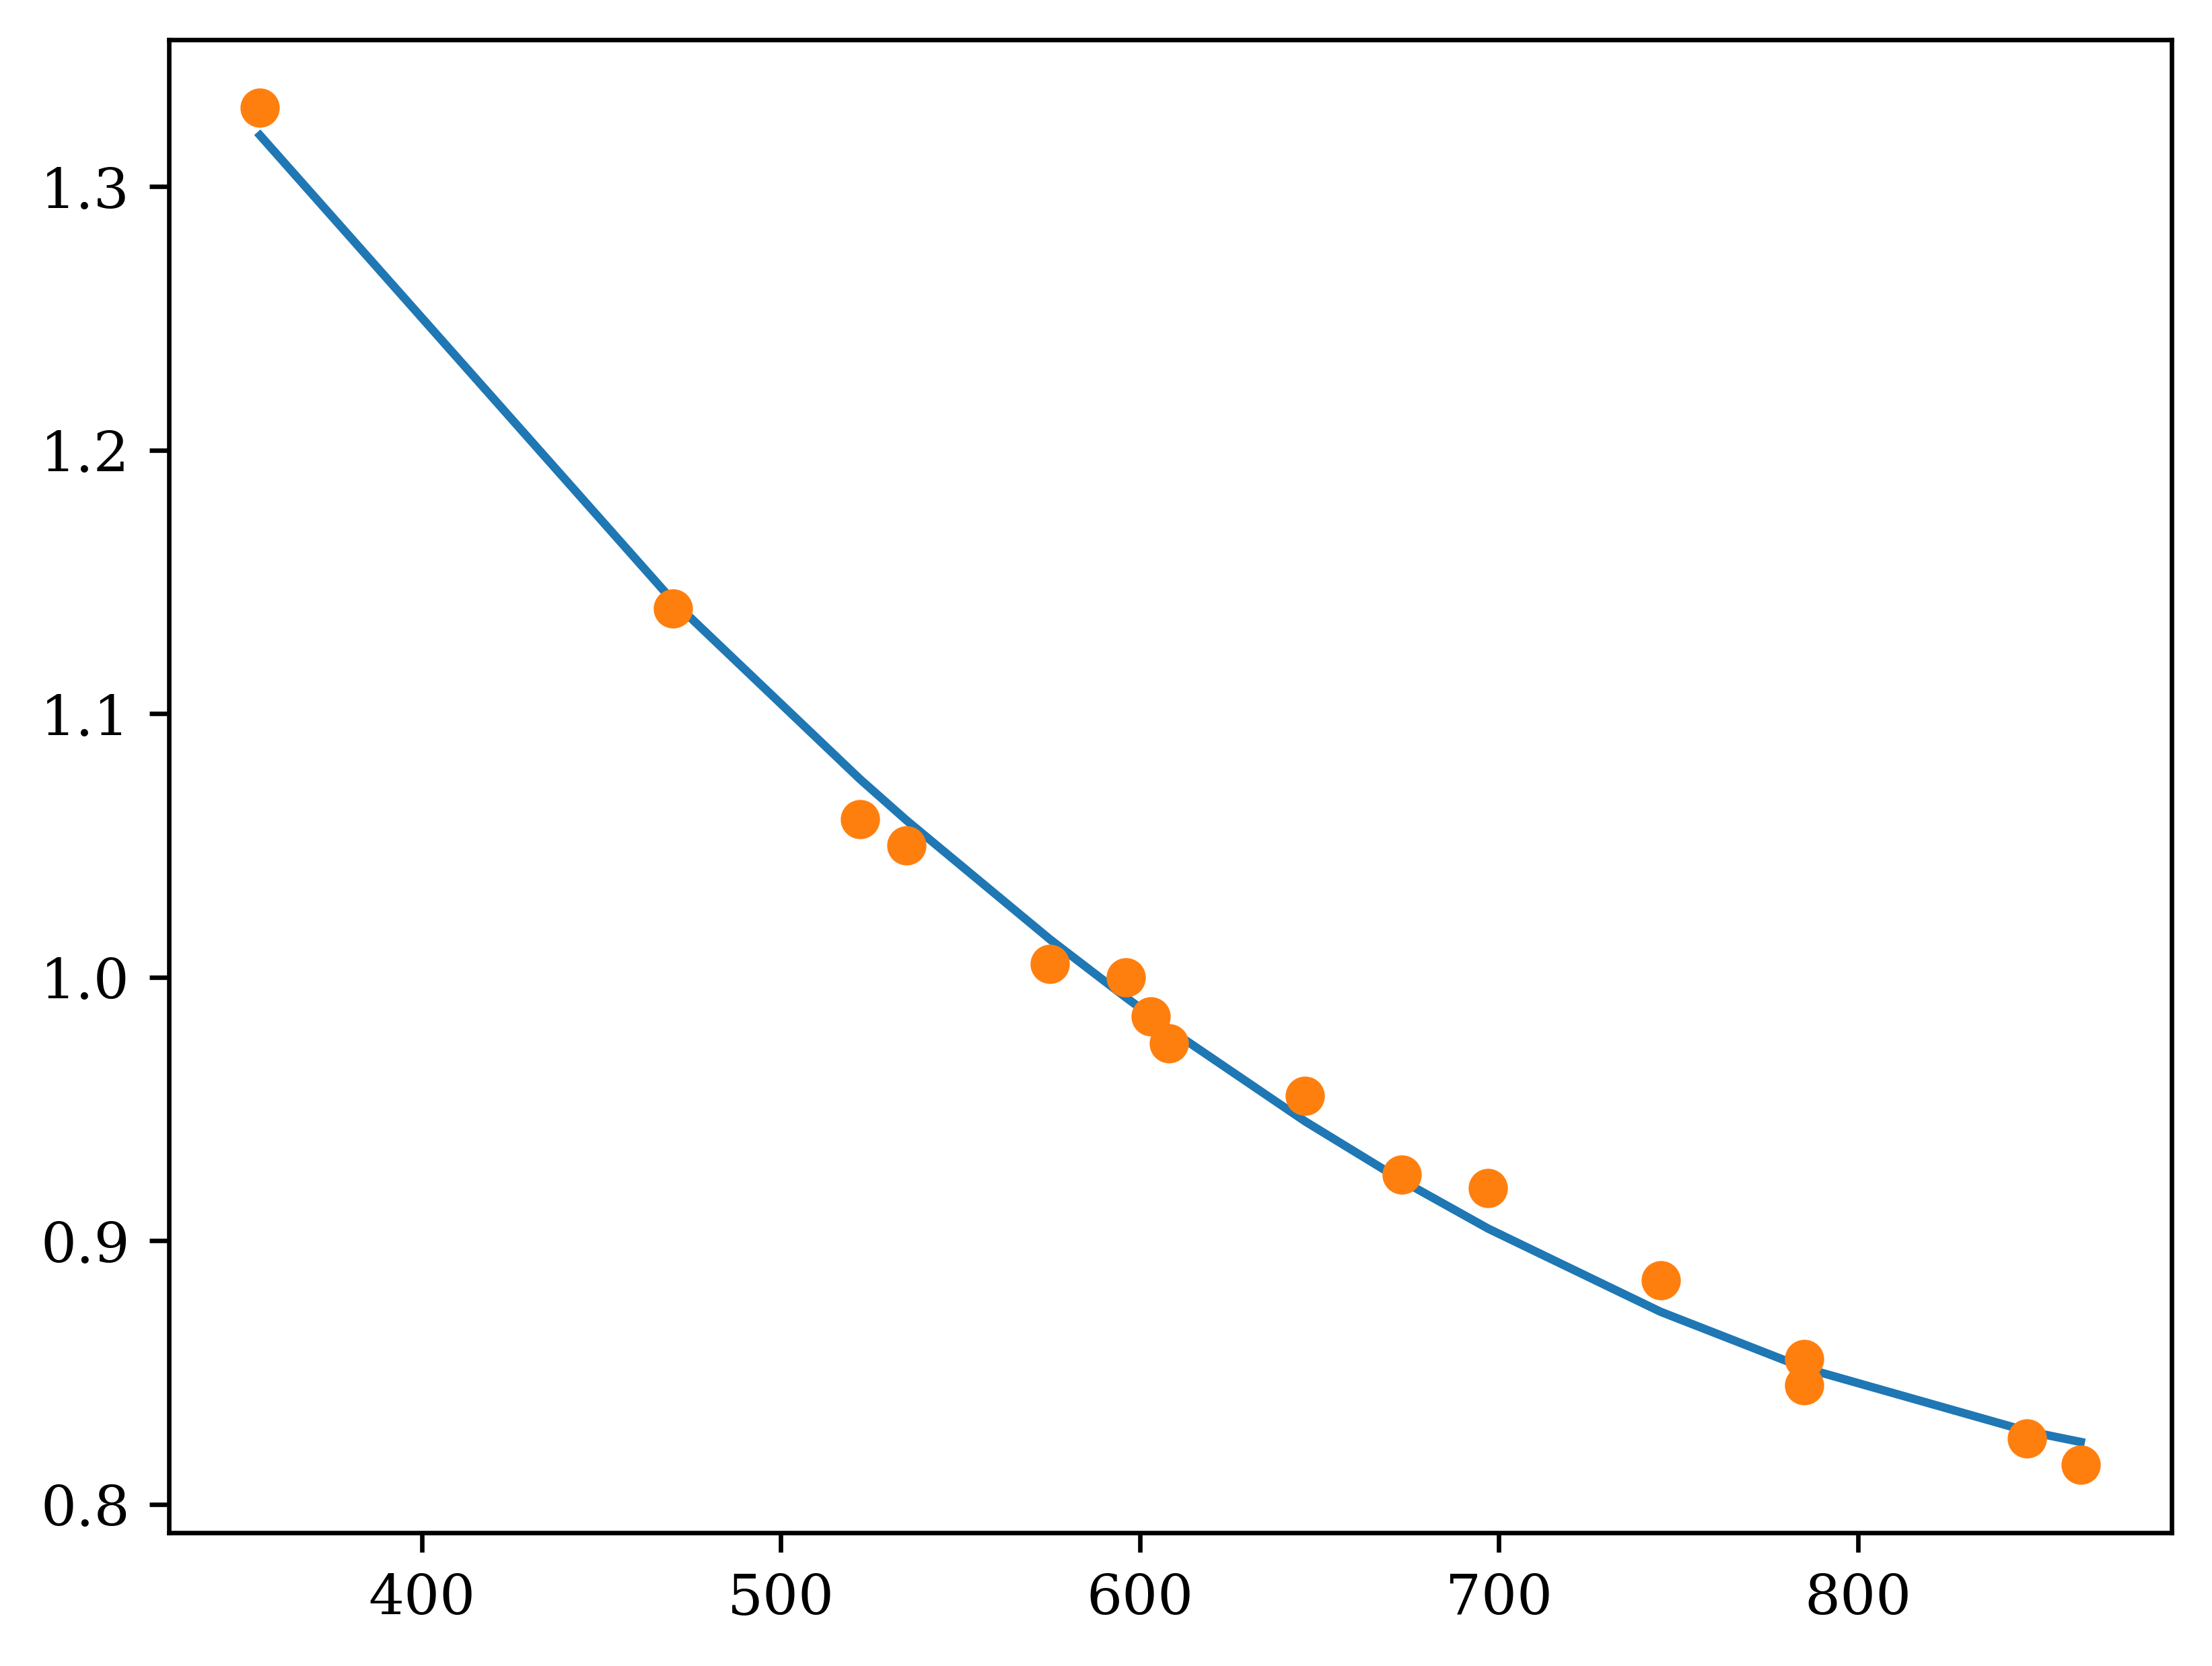

In [18]:
yhat = np.polyval(coefficients_quad, x)
idx = np.argsort(x)
plt.plot(np.array(x)[idx], yhat[idx])
plt.plot(x, y, 'o')

In [19]:
joblib.dump(dict(coef=coefficients_quad, fit_type='quad'), '/n/groups/datta/win/longtogeny/data/metadata/extraction_scaling.p')

['/n/groups/datta/win/longtogeny/data/metadata/extraction_scaling.p']